<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preparing-the-data" data-toc-modified-id="Preparing-the-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preparing the data</a></span><ul class="toc-item"><li><span><a href="#Using-PyTorch-and-PIL" data-toc-modified-id="Using-PyTorch-and-PIL-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Using PyTorch and PIL</a></span></li><li><span><a href="#Using-the-mid-level-API" data-toc-modified-id="Using-the-mid-level-API-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Using the mid-level API</a></span></li><li><span><a href="#Making-show-work" data-toc-modified-id="Making-show-work-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Making <code>show</code> work</a></span></li><li><span><a href="#show_batch()" data-toc-modified-id="show_batch()-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>show_batch()</a></span></li></ul></li></ul></div>

# Preparing the data
> `dss` → `dls`

## Using PyTorch and PIL

In [ ]:
from fastai.data.external import untar_data,URLs
from fastai.data.transforms import get_image_files
from fastcore.foundation import *

In [ ]:
path = untar_data(URLs.PETS)
files = get_image_files(path/"images")
files[0]

Path('/home/rory/.fastai/data/oxford-iiit-pet/images/japanese_chin_60.jpg')

In [ ]:
import PIL

(263, 380)


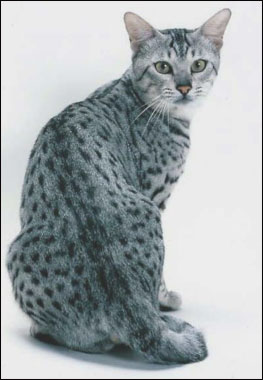

In [ ]:
im = PIL.Image.open(files[2])
print(im.size)
im

In [ ]:
import torch
import numpy as np

In [ ]:
def open_image(fname, size=224):
    im = PIL.Image.open(fname).convert('RGB')
    im = im.resize((size, size))
    t = torch.Tensor(np.array(im))
    return t.permute(2,0,1).float()/255.0

In [ ]:
print(open_image(files[2]).shape)
open_image(files[2])

torch.Size([3, 224, 224])


tensor([[[0.0941, 0.4078, 0.4078,  ..., 0.3922, 0.4078, 0.0941],
         [0.1490, 0.9765, 0.9608,  ..., 0.9569, 0.9490, 0.1529],
         [0.1490, 0.9255, 0.9255,  ..., 0.9098, 0.9255, 0.1529],
         ...,
         [0.1451, 0.9333, 0.9176,  ..., 0.9216, 0.9294, 0.1451],
         [0.1490, 0.9647, 0.9529,  ..., 0.9569, 0.9686, 0.1451],
         [0.0902, 0.4118, 0.4039,  ..., 0.4000, 0.4078, 0.0941]],

        [[0.0863, 0.4000, 0.4000,  ..., 0.3843, 0.4000, 0.0863],
         [0.1412, 0.9686, 0.9529,  ..., 0.9490, 0.9412, 0.1451],
         [0.1412, 0.9176, 0.9176,  ..., 0.9020, 0.9176, 0.1451],
         ...,
         [0.1412, 0.9294, 0.9176,  ..., 0.9176, 0.9294, 0.1451],
         [0.1412, 0.9569, 0.9451,  ..., 0.9451, 0.9569, 0.1373],
         [0.0824, 0.4039, 0.3961,  ..., 0.3922, 0.4000, 0.0863]],

        [[0.0902, 0.4039, 0.4039,  ..., 0.3882, 0.4039, 0.0902],
         [0.1451, 0.9725, 0.9569,  ..., 0.9529, 0.9490, 0.1490],
         [0.1451, 0.9216, 0.9216,  ..., 0.9137, 0.9294, 0.

In [ ]:
import re

In [ ]:
def label_func(fname): return re.match(r'^(.*)_\d+.jpg$', fname.name).groups()[0]

label_func(files[2])

'Egyptian_Mau'

In [ ]:
labels = L(set(files.map(label_func)))
len(labels)

37

In [ ]:
labels

(#37) ['english_cocker_spaniel','shiba_inu','Russian_Blue','english_setter','Persian','British_Shorthair','keeshond','samoyed','pug','Egyptian_Mau'...]

Helper function for passing in a class and getting back files of that class.

In [ ]:
lbl2files = {l: [f for f in files if label_func(f) == l] for l in labels}
lbl2files['Egyptian_Mau'][0:3]

[Path('/home/rory/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_90.jpg'),
 Path('/home/rory/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_84.jpg'),
 Path('/home/rory/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_187.jpg')]

In [ ]:
import random

In [ ]:
random.randrange(len(files))

0

In [ ]:
random.randrange(len(files))

1

Create dataset class

In [ ]:
class SiameseDataset(torch.utils.data.Dataset): # inherits from torch's Dataset
    def __init__(self, files, is_valid=False):  # init w/ list of files; is_valid=True if init'ing valid ds
        self.files, self.is_valid = files, is_valid
        if is_valid: self.files2 = [self._draw(f) for f in files] # fix validation set
        
    def __getitem__(self, i): # outputs (x1,x2,y). x2s are fixed for valid (see above) but not for train.
        file1 = self.files[i]
        (file2,same) = self.files2[i] if self.is_valid else self._draw(file1) 
        im1, im2 = open_image(file1), open_image(file2)
        return (im1, im2, torch.Tensor([same]).squeeze())
    
    def __len__(self): return len(self.files)
    
    def _draw(self, f):
        cls = label_func(f)
        same = random.random() < 0.5 # flip a coin: if True, file2 will be of same class as file1
        if not same: cls = random.choice([l for l in labels if l != cls]) # if not same, choose new cls
        return random.choice(lbl2files[cls]),same

Split train and valid

In [ ]:
random.choice([l for l in labels if l != 'Egyptian_Mau'])

'Ragdoll'

In [ ]:
ds = SiameseDataset(lbl2files['Egyptian_Mau'][0:3])

In [ ]:
ds[1]

(tensor([[[0.5882, 0.6039, 0.6824,  ..., 0.6157, 0.6157, 0.6118],
          [0.6157, 0.6196, 0.6627,  ..., 0.6118, 0.6118, 0.6118],
          [0.6667, 0.6627, 0.6706,  ..., 0.6078, 0.6078, 0.6078],
          ...,
          [0.5020, 0.5137, 0.5373,  ..., 0.5059, 0.5059, 0.5059],
          [0.5451, 0.5451, 0.5529,  ..., 0.5059, 0.5098, 0.5098],
          [0.5020, 0.4863, 0.4588,  ..., 0.5098, 0.5098, 0.5098]],
 
         [[0.6863, 0.6980, 0.7686,  ..., 0.5765, 0.5804, 0.5804],
          [0.7137, 0.7216, 0.7608,  ..., 0.5725, 0.5804, 0.5804],
          [0.7569, 0.7569, 0.7686,  ..., 0.5765, 0.5765, 0.5765],
          ...,
          [0.4745, 0.4863, 0.5137,  ..., 0.4863, 0.4863, 0.4863],
          [0.5137, 0.5098, 0.5176,  ..., 0.4863, 0.4863, 0.4902],
          [0.4627, 0.4471, 0.4196,  ..., 0.4863, 0.4863, 0.4863]],
 
         [[0.7059, 0.7059, 0.7608,  ..., 0.5294, 0.5294, 0.5294],
          [0.7294, 0.7216, 0.7490,  ..., 0.5255, 0.5294, 0.5294],
          [0.7922, 0.7804, 0.7804,  ...,

In [ ]:
idxs = np.random.permutation(range(len(files)))
cut = int(0.8 * len(files))
train_files = files[idxs[:cut]]
valid_files = files[idxs[cut:]]

In [ ]:
train_ds = SiameseDataset(train_files)
valid_ds = SiameseDataset(valid_files, is_valid=True)

In [ ]:
from fastai.data.core import DataLoaders

In [ ]:
dls = DataLoaders.from_dsets(train_ds,valid_ds)

In [ ]:
x1,x2,y = dls.one_batch()
x1.shape,x2.shape,y.shape

(torch.Size([64, 3, 224, 224]),
 torch.Size([64, 3, 224, 224]),
 torch.Size([64]))

In [ ]:
y

tensor([0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1.,
        0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0.,
        1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1.,
        0., 0., 1., 1., 1., 1., 0., 1., 1., 1.])

With minimal changes to the code we wrote, we can access all of fastai's transforms and augmentations. That's next.

## Using the mid-level API

When I have a custom dataset class, I can easily convert it into a fastai Transform by just changing the `__getitem__` to `encodes` and setting the class to inherit from `Transform`. 

In [ ]:
from fastai.vision.all import *

In [ ]:
class SiameseTransform(Transform): # inherits from torch's Dataset
    def __init__(self, files, is_valid=False):  # init w/ list of files; is_valid=True if init'ing valid ds
        self.files, self.is_valid = files, is_valid
        if is_valid: self.files2 = [self._draw(f) for f in files] # fix validation set
        
    def encodes(self, i): # given an index of an item in the list, return transformed item
        file1 = self.files[i]
        (file2,same) = self.files2[i] if self.is_valid else self._draw(file1) 
        im1, im2 = open_image(file1), open_image(file2)
        return (TensorImage(im1), TensorImage(im2), torch.Tensor([same]).squeeze())
    
    def _draw(self, f):
        cls = label_func(f)
        same = random.random() < 0.5 # flip a coin: if True, file2 will be of same class as file1
        if not same: cls = random.choice([l for l in labels if l != cls]) # if not same, choose new cls
        return random.choice(lbl2files[cls]),same

We will use SiameseTransform to build a dls from transformed lists.

In [ ]:
train_tl = TfmdLists(range(len(train_files)), SiameseTransform(train_files))
valid_tl = TfmdLists(range(len(valid_files)), SiameseTransform(valid_files, is_valid=True))

In [ ]:
dls = DataLoaders.from_dsets(train_tl, valid_tl,
                             after_batch=[Normalize.from_stats(*imagenet_stats), *aug_transforms()])

In [ ]:
dls = dls.cuda()

Now we have the transforms from fastai working. Next, we will make `show` work.

## Making `show` work

In [ ]:
class SiameseImage(fastuple):
    def show(self, ctx=None, **kwargs):
        # unpack tuple
        if len(self) > 2:
            im1, im2, similarity = self
        else:
            im1, im2 = self
            similarity = 'Undetermined'
        # ensure ims are tensors
        if not isinstance(im1, Tensor):
            if im2.size != im1.size: im2 = im2.resize(im1.size)
            t1, t2 = tensor(im1), tensor(im2)
            t1, t2 = t1.permute(2,0,1), t2.permute(2,0,1)
        else: t1, t2 = im1, im2
        # create padding
        padding = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        # concat t1,padding,t2 into a single tensor and return
        return show_image(torch.cat([t1, padding, t2], dim=2), title=similarity, ctx=ctx, **kwargs)

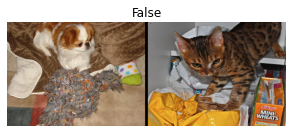

In [ ]:
im0 = PILImage.create(files[0])
im1 = PILImage.create(files[1])
s = SiameseImage(im0,im1,False)
s.show();

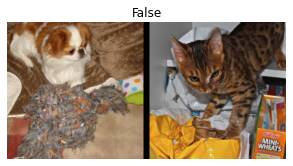

In [ ]:
tst = Resize(228)(s)
tst = ToTensor()(tst)
tst.show();

Now let's rewrite the `SiameseTransform` so that `encodes` returns a `SiameseImage`. We'll also make it compliant with some fastai best practices, e.g., determining train and valid by passing in a function that returns two lists of indexes.

In [ ]:
class SiameseTransform(Transform):
    def __init__(self, files, splits):
        self.valid = {f: self._get_f2(f) for f in files[splits[1]]} # store map of im1:im2 for files in valid split
        
    def encodes(self, f):
        f2, same = self.valid.get(f, self._get_f2(f)) # if f in valid, return valid['f']; else create new f2
        im1, im2 = PILImage.create(f), PILImage.create(f2)
        return SiameseImage(im1, im2, same)
        
    def _get_f2(self, f):
        cls = label_func(f)
        same = random.random() < 0.5 # flip a coin: if True, file2 will be of same class as file1
        if not same: cls = random.choice([l for l in labels if l != cls]) # if not same, choose new cls
        return random.choice(lbl2files[cls]),same

In [ ]:
splits = RandomSplitter()(files)
tfm = SiameseTransform(files, splits)

In [ ]:
tls = TfmdLists(files, tfm, splits=splits)

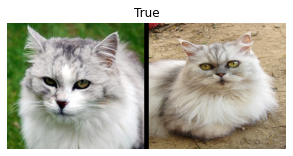

In [ ]:
show_at(tls.valid, 1);

In [ ]:
dls = tls.dataloaders(after_item=[Resize(224), ToTensor],
                      after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

When calling show_batch on dls, fastai will send the batch to the type-dispatched function for showing batches of type SiameseImage. Let's make that method now!

## show_batch()

In [ ]:
@typedispatch
def show_batch(x:SiameseImage, y, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs):
        SiameseImage(x[0][i], x[1][i], ['Not similar','Similar'][x[2][i].item()]).show(ctx=ctx)

In [ ]:
b = dls.one_batch()

In [ ]:
dls._types

{__main__.SiameseImage: [fastai.torch_core.TensorImage,
  fastai.torch_core.TensorImage,
  torch.Tensor]}

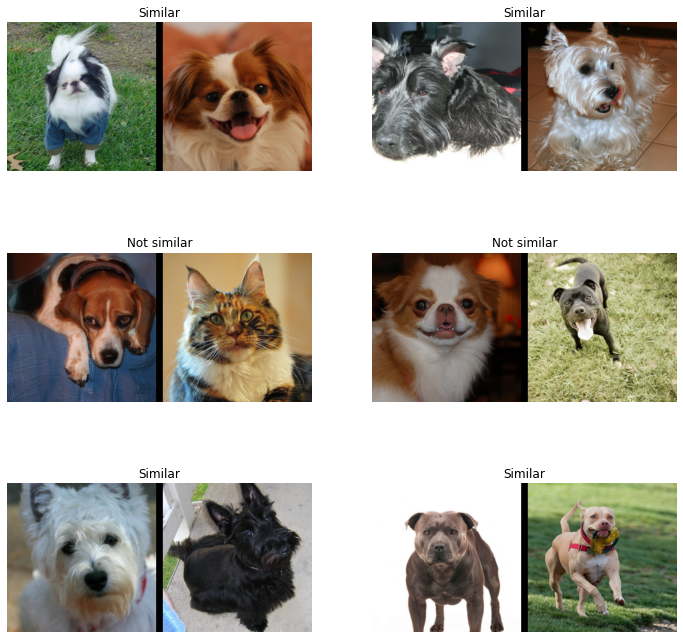

In [ ]:
dls.show_batch()